### Intro: For new wells, regression is used for prediction. The First 6 months avg. productions are predicted.

### 1. Importing packages

In [ ]:
!pip install 'ray[tune]'

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
import ray
from ray import tune

### 2. Loading datasets

In [ ]:
train_df = pd.read_csv('trainSet.csv', index_col=1)
exam_df = pd.read_csv('examSet.csv', index_col=1)

In [ ]:
# visualizing missing values in train dataset
train_df_isnull = train_df.isnull()
train_df_isnull = train_df_isnull * 1

x = list(train_df.columns)
y = np.arange(0, train_df.shape[0])
z = train_df_isnull.to_numpy()

fig = go.Figure(go.Heatmap(x=x, y=y, z=z))
fig.update_yaxes(autorange='reversed')
fig.update_layout(title='Missing values in Train dataset')
fig.show()

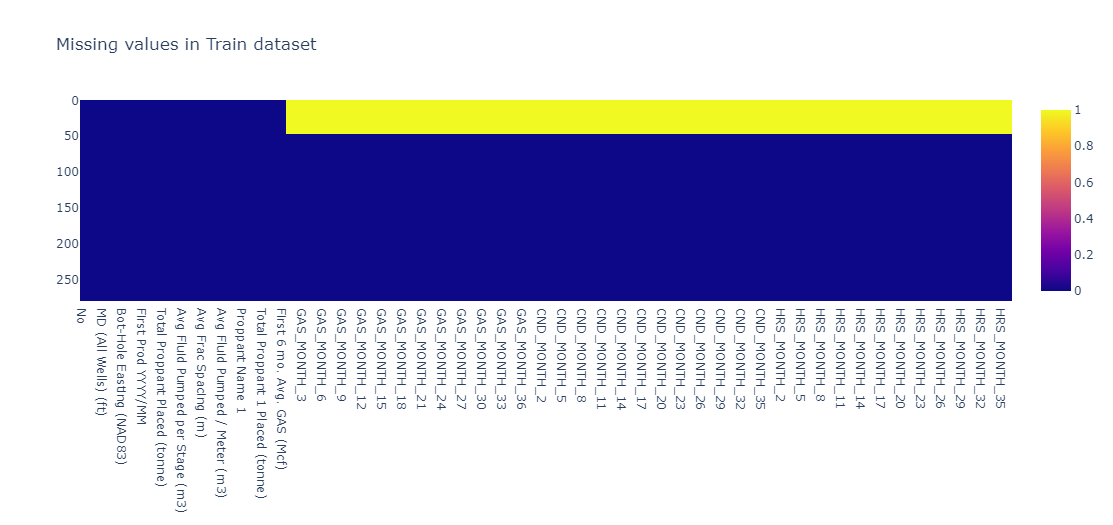

In [ ]:
# visualizing missing values in exam dataset
exam_df_isnull = exam_df.isnull()
exam_df_isnull = exam_df_isnull * 1

x = list(exam_df.columns)
y = np.arange(0, exam_df.shape[0])
z = exam_df_isnull.to_numpy()

fig = go.Figure(go.Heatmap(x=x, y=y, z=z))
fig.update_yaxes(autorange='reversed')
fig.update_layout(title='Missing values in Exam dataset')
fig.show()

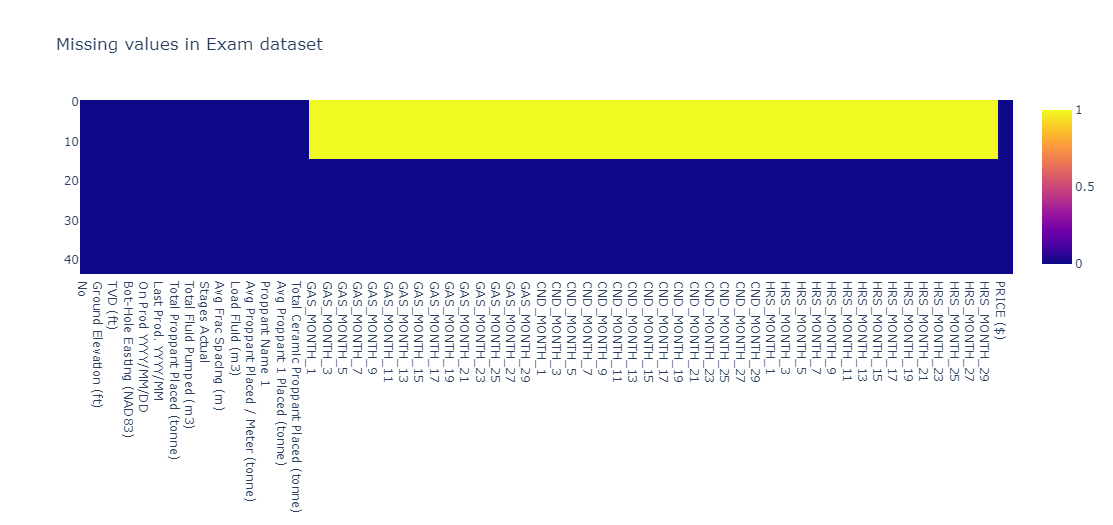

### 3. Feature engineering

In [ ]:
# dropping columns from train dataset
drop_cols = []
for i in range(36):
    drop_cols.append('GAS_MONTH_' + str(i+1))
    drop_cols.append('CND_MONTH_' + str(i+1))
    drop_cols.append('HRS_MONTH_' + str(i+1))
drop_cols.extend(['No', 'Last 6 mo. Avg. GAS (Mcf)'])

Xy_train = train_df.drop(drop_cols, axis=1)
Xy_train.shape

(280, 30)

In [ ]:
# splitting features and response in train dataset
X_train = Xy_train.drop('First 6 mo. Avg. GAS (Mcf)', axis=1)
y_train = Xy_train[['First 6 mo. Avg. GAS (Mcf)']]

print(X_train.shape)
print(y_train.shape)

(280, 29)
(280, 1)


In [ ]:
# selecting new wells from exam dataset
X_exam = exam_df.iloc[:15,:]

# dropping columns from exam dataset
drop_cols = []
for i in range(30):
    drop_cols.append('GAS_MONTH_' + str(i+1))
    drop_cols.append('CND_MONTH_' + str(i+1))
    drop_cols.append('HRS_MONTH_' + str(i+1))
drop_cols.extend(['No', 'PRICE ($)', 'Per Month Operation Cost ($)'])

X_exam = X_exam.drop(drop_cols, axis=1)
X_exam.shape

(15, 29)

In [ ]:
# combining train and exam features
X_combined = pd.concat([X_train, X_exam], axis=0)
X_combined.shape

(295, 29)

In [ ]:
# dropping unnecessary columns from combined dataset
drop_cols = ['Avg Proppant Placed per Stage (tonne)', 
             'Avg Fluid Pumped per Stage (m3)', 
             'Load Fluid Rec (m3)', 
             'Avg Fluid Pumped / Meter (m3)', 
             'Avg Proppant Placed / Meter (tonne)', 
             'Avg Proppant 1 Placed (tonne)', 
             'Total Ceramic Proppant Placed (tonne)']

X_combined = X_combined.drop(drop_cols, axis=1)
X_combined.shape

(295, 22)

In [ ]:
# function to get categorical columns
def get_cat_cols(df):
    num_cols = df._get_numeric_data().columns
    cat_cols = list(set(df.columns) - set(num_cols))
    return cat_cols

In [ ]:
# getting categorical columns from combined dataset
get_cat_cols(X_combined)

['Stimulation Fluid',
 'Last Prod. YYYY/MM',
 'On Prod YYYY/MM/DD',
 'Proppant Composition',
 'First Prod YYYY/MM',
 'Proppant Size 1',
 'Proppant Name 1']

In [ ]:
# function to convert dates to numerical values
def convert_dates(df):
    df['On Prod YYYY/MM/DD'] = pd.to_datetime(df['On Prod YYYY/MM/DD'], format='%Y.%m.%d')
    df['First Prod YYYY/MM'] = pd.to_datetime(df['First Prod YYYY/MM'], format='%Y.%m.%d')
    df['Last Prod. YYYY/MM'] = pd.to_datetime(df['Last Prod. YYYY/MM'], format='%Y.%m.%d')

    s1 = df['On Prod YYYY/MM/DD'] - df['First Prod YYYY/MM']
    df['FirstProdtoOnProdDays'] = s1.dt.days

    s2 = df['Last Prod. YYYY/MM'] - df['First Prod YYYY/MM']
    df['FirstProdtoLastProdDays'] = s2.dt.days

    df = df.drop(['On Prod YYYY/MM/DD', 'First Prod YYYY/MM', 'Last Prod. YYYY/MM'], axis=1)
    
    return df

In [ ]:
# converting dates to numerical values
X_combined = convert_dates(X_combined)
X_combined.shape

(295, 21)

In [ ]:
# getting remaining categorical columns from combined dataset
cat_cols = get_cat_cols(X_combined)
cat_cols

['Stimulation Fluid',
 'Proppant Size 1',
 'Proppant Composition',
 'Proppant Name 1']

In [ ]:
# imputing 0 values in Proppant Size 1
X_combined['Proppant Size 1'] = np.where(
    (X_combined['Proppant Size 1'] == '0') & (X_combined['Proppant Name 1'] == 'Sand'), 
    '40/70', 
    X_combined['Proppant Size 1'])

In [ ]:
X_combined['Proppant Size 1'] = np.where(
    (X_combined['Proppant Size 1'] == '0') & (X_combined['Proppant Name 1'] == 'HydroProp'), 
    '40/80', 
    X_combined['Proppant Size 1'])

In [ ]:
# getting number of categories in categorical columns
for col in cat_cols:
    print(col + ' : ' + str(len(X_combined[col].unique())))

Stimulation Fluid : 21
Proppant Size 1 : 5
Proppant Composition : 2
Proppant Name 1 : 13


In [ ]:
# one hot encoding categorical columns
X_combined_dummies = pd.get_dummies(data=X_combined, columns=cat_cols)
X_combined_dummies.shape

(295, 58)

### 4. EDA (Exploratory Data Analysis)

In [ ]:
# function to split combined dataset into train and exam
def split_train_exam(X_combined, n):
    X_train = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_train, X_exam

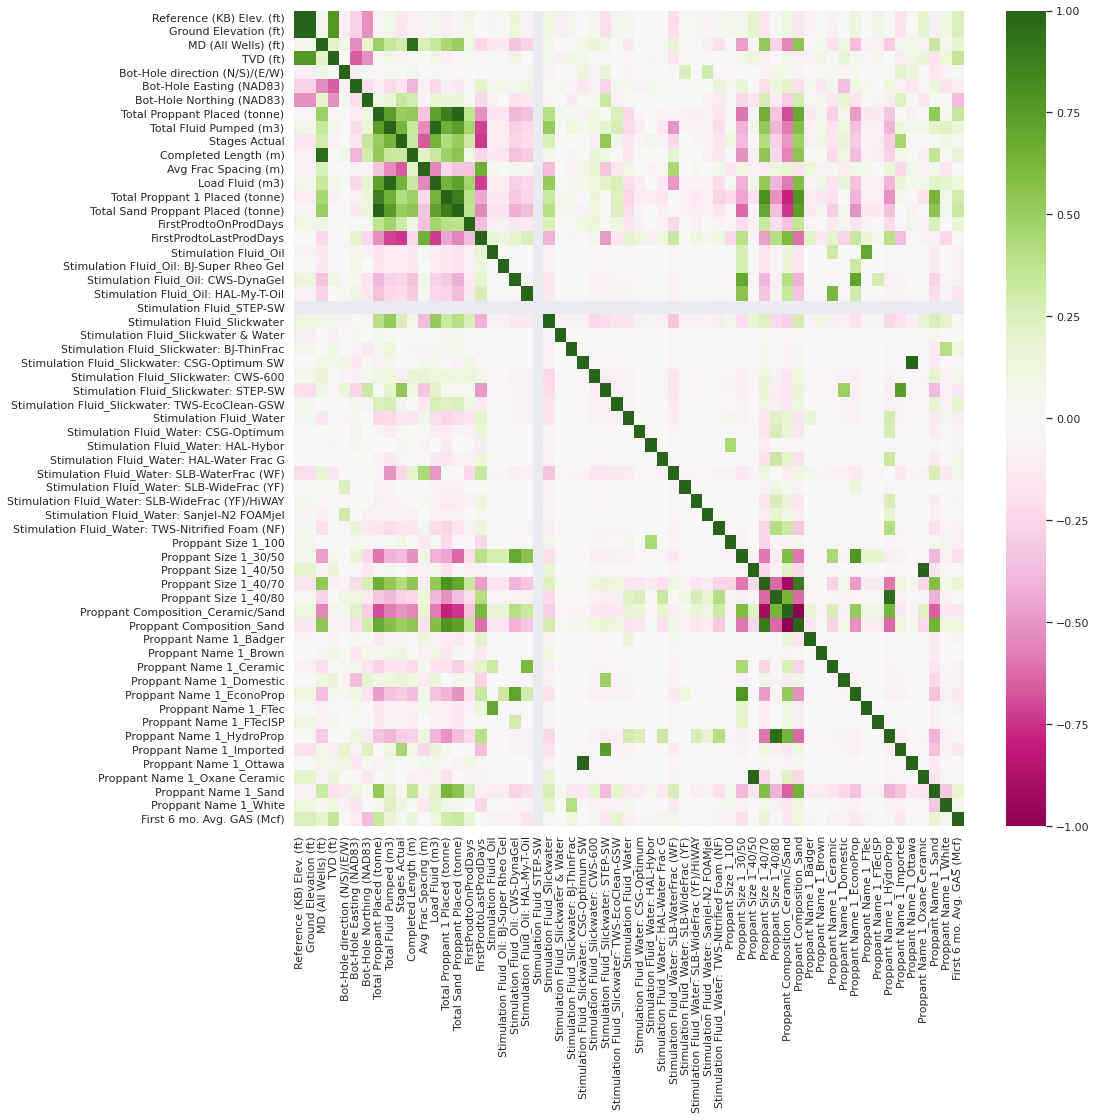

In [ ]:
# creating correlation matrix
X_train, X_exam = split_train_exam(X_combined_dummies, X_train.shape[0])

Xy_train = pd.concat([X_train, y_train], axis=1)

corr = Xy_train.corr()

sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='PiYG')

In [ ]:
# creating correlation scatter plot with response
corr = []
for col in list(X_train.columns):
    c = y_train['First 6 mo. Avg. GAS (Mcf)'].corr(X_train[col])
    corr.append(c)

fig = go.Figure(go.Scatter(x=X_train.columns, 
                           y=corr, 
                           mode='markers', 
                           marker_color='chocolate'))
fig.update_layout(title='Corr with First 6 months avg.')
fig.show()

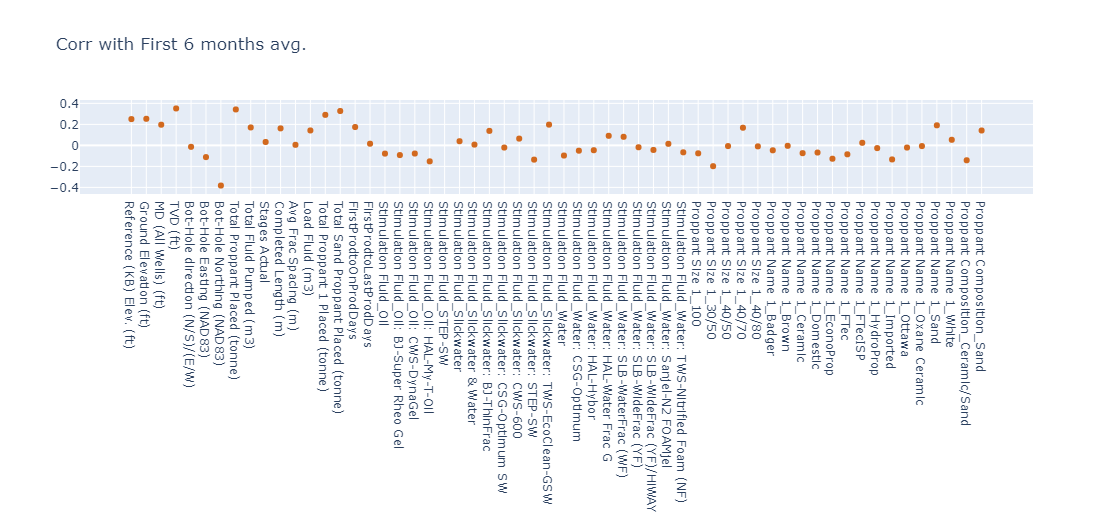

### 5. Performance evaluation

In [ ]:
# function for performance evaluation
def model_perf(model, X, y):
    y_hat = model.predict(X)
    y_true = y['First 6 mo. Avg. GAS (Mcf)'].to_numpy()
    smape = 100 / len(y_true) * np.sum(2 * np.abs(y_hat - y_true) / (np.abs(y_hat) + np.abs(y_true)))
    return smape

# function for fitting and evaluating model
def model_fit_eval(model, X_all, y_all):
    X_trn, X_val, y_trn, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
    model.fit(X_trn, y_trn)
    smape = model_perf(model, X_val, y_val)
    return smape

### 6. Model selection

In [ ]:
# creating models
b = BaggingRegressor(n_estimators=50)
rf = RandomForestRegressor(n_estimators=50)
xgb = XGBRegressor(max_depth=5, objective='reg:squarederror')
lgbm = LGBMRegressor()

estms = [('b', b), ('rf', rf), ('xgb', xgb), ('lgbm', lgbm)]
v = VotingRegressor(estimators=estms, n_jobs=-1) # using all processors

In [ ]:
# fitting and evaluating models
b_smape = model_fit_eval(b, X_train, y_train)
rf_smape = model_fit_eval(rf, X_train, y_train)
xgb_smape = model_fit_eval(xgb, X_train, y_train)
lgbm_smape = model_fit_eval(lgbm, X_train, y_train)
v_smape = model_fit_eval(v, X_train, y_train)

In [ ]:
# comparing performances of models
models = ['Bagging', 'Random Forest', 'XGBoost', 'LGBM', 'Voting']
smapes = [b_smape, rf_smape, xgb_smape, lgbm_smape, v_smape]

fig = go.Figure(go.Bar(x=models, 
                       y=smapes, 
                       text=smapes))

fig.update_traces(texttemplate='%{text:.4f}', textposition='inside')
fig.update_layout(title='Models sMAPE scores', 
                  xaxis=dict(title='Models'), 
                  yaxis=dict(title='Scores'))
fig.show()
# best model lgbm (min sMAPE score)

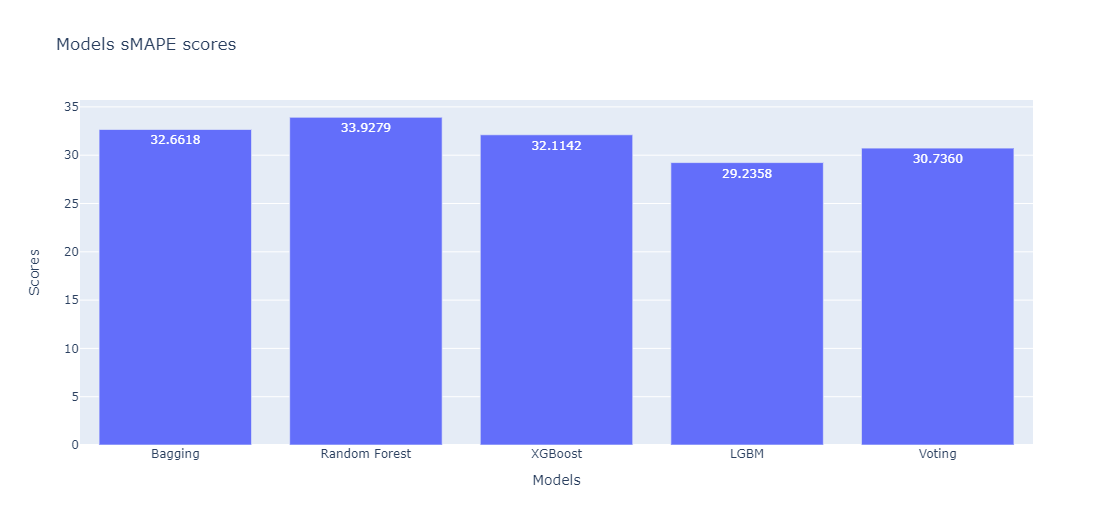

### 7. Hyperparameter tuning

In [ ]:
# starting ray runtime
ray.init()

{'metrics_export_port': 54137,
 'node_id': '16ac02b6fabea42041bdef0f64912f939667948966e0a6efdbb1e9b1',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2022-02-04_15-43-43_798192_81/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2022-02-04_15-43-43_798192_81/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2022-02-04_15-43-43_798192_81',
 'webui_url': None}

In [ ]:
# checking available resources
ray.cluster_resources()

{'CPU': 2.0,
 'GPU': 1.0,
 'accelerator_type:K80': 1.0,
 'memory': 7138870887.0,
 'node:172.28.0.2': 1.0,
 'object_store_memory': 3569435443.0}

In [ ]:
# function for training model using different hyperparameters
def train_model(config):
    # defaults
    model = LGBMRegressor(boosting_type=config['boosting_type'], # gbdt
                          learning_rate=config['learning_rate'], # 0.1
                          max_bin=config['max_bin'], # 255
                          max_depth=config['max_depth'], # -1
                          min_data_in_leaf=config['min_data_in_leaf'], # 20
                          num_iterations=config['num_iterations'], # 100
                          num_leaves=config['num_leaves']) # 31
    
    smape = model_fit_eval(model, X_train, y_train)
    tune.report(smape=smape)

In [ ]:
# using grid search to get best hyperparameters
analysis = tune.run(
    train_model, 
    config={'boosting_type':tune.grid_search(['gbdt', 'dart', 'goss']), 
            'learning_rate':tune.grid_search([0.05, 0.1, 0.15]), 
            'max_bin':tune.grid_search([200, 250, 300]), 
            'max_depth':tune.grid_search([-1, 1, 2]), 
            'min_data_in_leaf':tune.grid_search([10, 20, 30]), 
            'num_iterations':tune.grid_search([50, 100, 150]), 
            'num_leaves':tune.grid_search([20, 30, 40])}, 
    resources_per_trial={'cpu':2, 'gpu':1}) # leveraging all resources

In [ ]:
# visualizing hyperparameter tuning results
%load_ext tensorboard
%tensorboard --logdir ~/ray_results

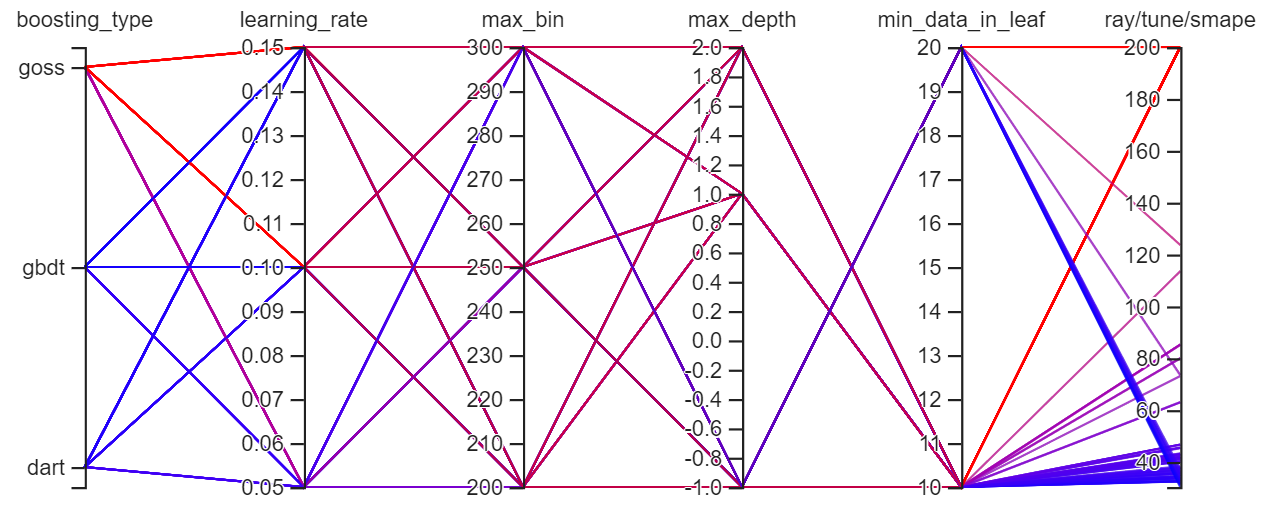

In [ ]:
# best hyperparameters
best_trial = analysis.get_best_trial(metric='smape', mode='min', scope='all')
min_smape = best_trial.metric_analysis['smape']['avg']
print(f'Min sMAPE: {min_smape}')
best_trial_config = best_trial.config
print(f'Best trial config:')
best_trial_config

Min sMAPE: 29.20800132341391
Best trial config:


{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_bin': 250,
 'max_depth': -1,
 'min_data_in_leaf': 20,
 'num_iterations': 100,
 'num_leaves': 40}

In [ ]:
# building model using best hyperparameters
lgbm1 = LGBMRegressor(boosting_type=best_trial_config['boosting_type'], 
                      learning_rate=best_trial_config['learning_rate'], 
                      max_bin=best_trial_config['max_bin'], 
                      max_depth=best_trial_config['max_depth'], 
                      min_data_in_leaf=best_trial_config['min_data_in_leaf'], 
                      num_iterations=best_trial_config['num_iterations'], 
                      num_leaves=best_trial_config['num_leaves'])
lgbm1_smape = model_fit_eval(lgbm1, X_train, y_train)
print(lgbm_smape)
print(lgbm1_smape) # same as lgbm_smape

29.235754789983343
29.235754789983343


In [ ]:
# shutting down ray runtime
ray.shutdown()

### 8. Feature importance

In [ ]:
# getting top 10 most important features
feature_results = pd.DataFrame({'Feature': list(X_train.columns), 
                                'Importance': lgbm1.feature_importances_})

feature_results = feature_results.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_results['Rank'] = np.arange(1, len(feature_results)+1, 1)
feature_results_rank = feature_results.set_index('Rank')
feature_results_rank = feature_results_rank[['Feature', 'Importance']]
feature_results_rank.head(10)

,Feature,Importance
Rank,,
1,TVDft,108
2,BotHoleEastingNAD83,100
3,BotHoleNorthingNAD83,87
4,BotHoledirectionNSEW,64
5,CompletedLengthm,60
6,TotalProppantPlacedtonne,48
7,MDAllWellsft,47
8,AvgFracSpacingm,42
9,FirstProdtoOnProdDays,41


### 9. Prediction

In [ ]:
# predicting responses for exam dataset
first_6_avg_pred = lgbm1.predict(X_exam)

pred_df = pd.read_csv('pred.csv')
pred_df['First 6 Avg'] = first_6_avg_pred

pred_df.to_csv('pred1.csv')